#Why Too Many Features Can Hurt Your Model

##Part 1: Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')


##Part 2: Load Data

In [2]:
# Load California Housing dataset
housing = fetch_california_housing()
X = housing.data
y = housing.target
feature_names = housing.feature_names

# Create a DataFrame for easier data manipulation
df = pd.DataFrame(X, columns=feature_names)
df['MedHouseVal'] = y

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Number of features: {len(feature_names)}")
print("\nFeature descriptions:")
print(housing.DESCR[:500] + "...")  # Show description but truncate it

Dataset shape: (20640, 9)
Number of features: 8

Feature descriptions:
.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group popu...


##Step 3: The Problem - Curse of Dimensionality


In [3]:
# As this is a regression problem, let's convert it to binary classification
# by setting threshold at median house price for logistic regression
median_price = np.median(y)
y_binary = (y > median_price).astype(int)

# #added during screencast
# Train a model with all features
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nLogistic Regression accuracy with all {len(feature_names)} features: {accuracy:.4f}")

# Show feature importance (coefficients)
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(model.coef_[0])
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

print("\nFeature importance:")
print(feature_importance)

print("\nInsight: More features don't always mean better models.")
print("They can increase computation time, cause overfitting, and add noise.")


Logistic Regression accuracy with all 8 features: 0.8272

Feature importance:
      Feature  Importance
6    Latitude    3.541967
7   Longitude    3.359696
0      MedInc    2.556861
5    AveOccup    2.028507
3   AveBedrms    0.972116
2    AveRooms    0.858748
1    HouseAge    0.251734
4  Population    0.046355

Insight: More features don't always mean better models.
They can increase computation time, cause overfitting, and add noise.


##Step 4: Visualizing High-Dimensional Data


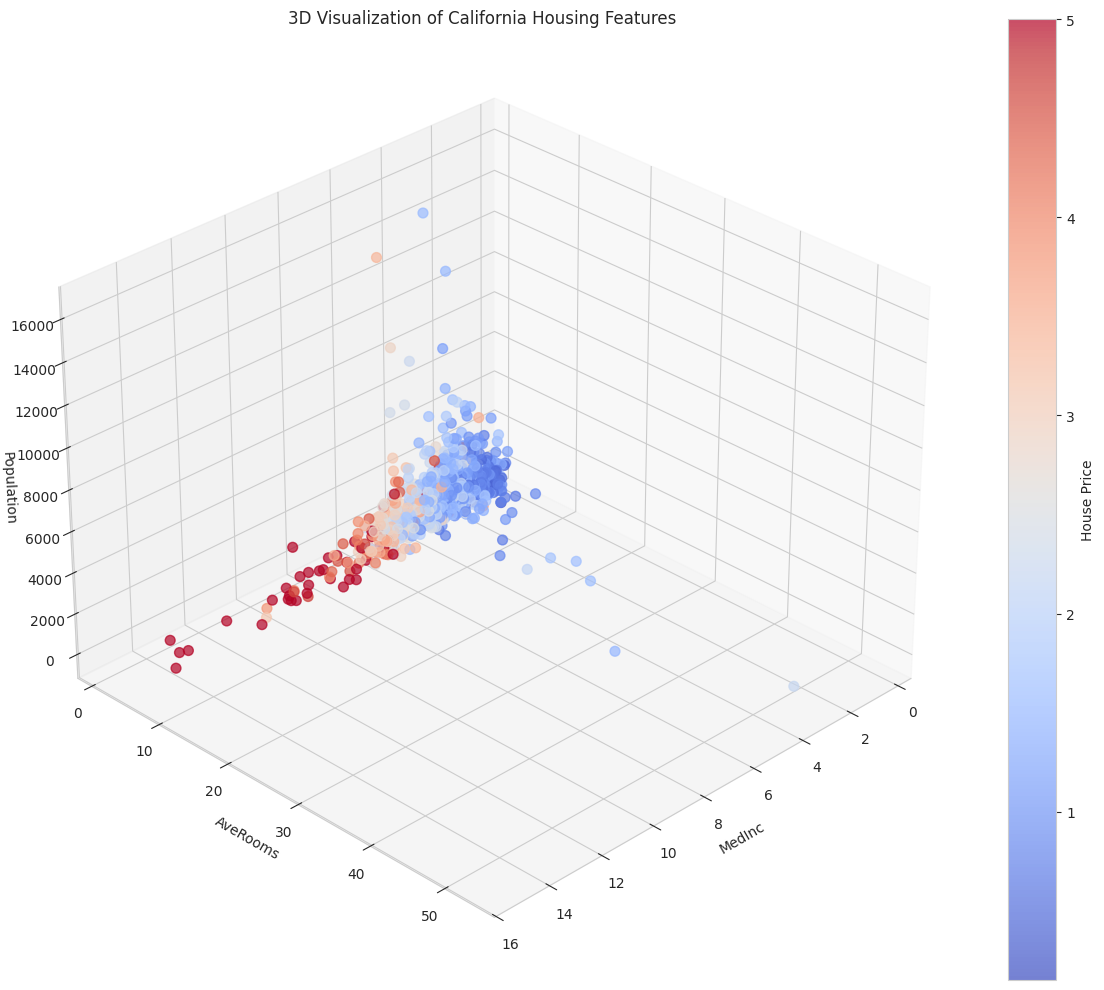

Visualizing 3 out of 8 features already becomes complex.
Imagine if we had 100 features—how do we visualize and simplify that?


In [4]:

# Select three interesting features for 3D visualization
# For California dataset, let's pick:
# MedInc (median income), AveRooms (average rooms), and Population
selected_features = ['MedInc', 'AveRooms', 'Population']
feature_indices = [list(feature_names).index(feature) for feature in selected_features]

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Sample 1000 points for clearer visualization (California dataset is large)
sample_idx = np.random.choice(X.shape[0], 1000, replace=False)

# Color points based on price (red for high, blue for low)
scatter = ax.scatter(
    X[sample_idx, feature_indices[0]],
    X[sample_idx, feature_indices[1]],
    X[sample_idx, feature_indices[2]],
    c=y[sample_idx],
    cmap='coolwarm',
    s=50,
    alpha=0.7
)

# Add labels and title
ax.set_xlabel(selected_features[0])
ax.set_ylabel(selected_features[1])
ax.set_zlabel(selected_features[2])
ax.set_title('3D Visualization of California Housing Features')

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('House Price')

# Rotate the plot for better visualization
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()

print("Visualizing 3 out of 8 features already becomes complex.")
print("Imagine if we had 100 features—how do we visualize and simplify that?")

#Applying Feature Selection & PCA in Python

##Step 1: Feature Selection Using Recursive Feature Elimination (RFE)


In [5]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import pandas as pd

# Prepare data
X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']

# RFE Model
model = LinearRegression()
rfe = RFE(model, n_features_to_select=5)  # Select top 5 features
X_rfe = rfe.fit_transform(X, y)
selected_features_rfe = X.columns[rfe.support_] # Renamed variable to avoid conflict
print("Selected Features (RFE):", selected_features_rfe)

# Get feature ranking
feature_ranking = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': rfe.ranking_
})
print("\nFeature Ranking (RFE - lower is better):")
print(feature_ranking.sort_values('Ranking'))

Selected Features (RFE): Index(['MedInc', 'AveRooms', 'AveBedrms', 'Latitude', 'Longitude'], dtype='object')

Feature Ranking (RFE - lower is better):
      Feature  Ranking
0      MedInc        1
2    AveRooms        1
3   AveBedrms        1
7   Longitude        1
6    Latitude        1
1    HouseAge        2
5    AveOccup        3
4  Population        4


##Step 2: Applying PCA in Python


Explained Variance Ratio (PCA): [0.25336868 0.23516245 0.15888635 0.12887971 0.12538195]
Total Variance Explained (PCA): 90.17%


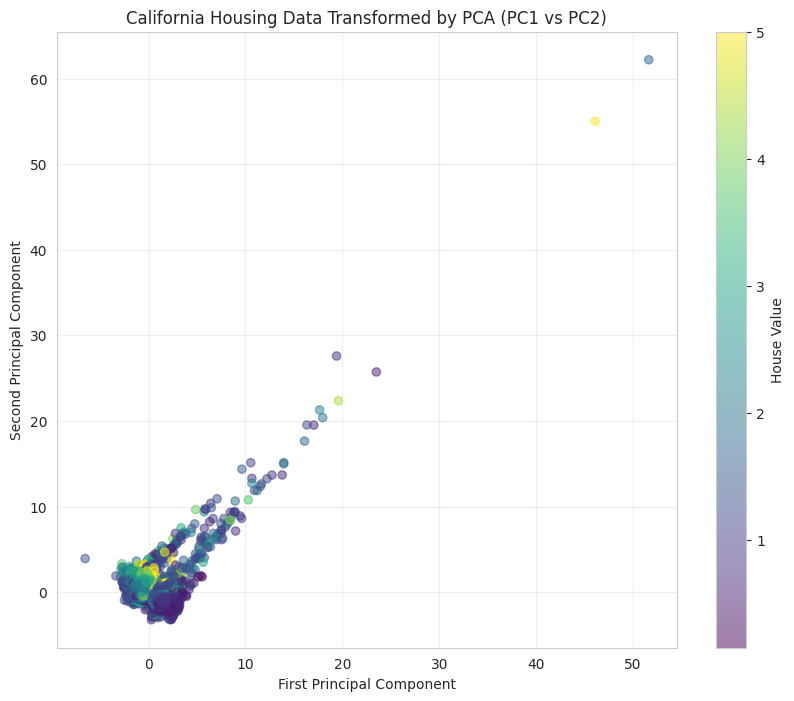

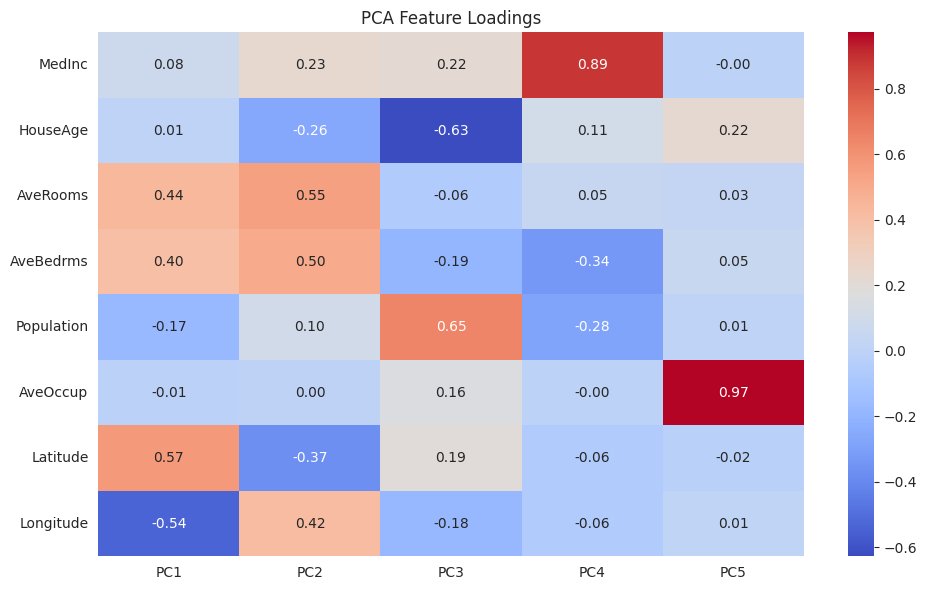

In [6]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler # Ensure StandardScaler is imported
import pandas as pd

# Standardize the features first (important for PCA)
X_scaled = StandardScaler().fit_transform(X)

# Applying PCA
n_components_chosen = 5 # Define or change the number of components here if you wish to experiment
pca = PCA(n_components=n_components_chosen)
X_pca = pca.fit_transform(X_scaled)

# Variance explained by selected components
print("Explained Variance Ratio (PCA):", pca.explained_variance_ratio_)
print("Total Variance Explained (PCA): {:.2f}%".format(sum(pca.explained_variance_ratio_) * 100))

# Create a DataFrame with PCA results for easier plotting
# Dynamically create column names based on n_components_chosen
pca_column_names = [f'PC{i+1}' for i in range(n_components_chosen)]
pca_df = pd.DataFrame(data=X_pca, columns=pca_column_names)
pca_df['MedHouseVal'] = y

# Visualize the transformed data (still only showing PC1 vs PC2 for 2D plot)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='House Value')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('California Housing Data Transformed by PCA (PC1 vs PC2)')
plt.grid(True, alpha=0.3)
plt.show()

# Loadings plot to understand what original features contribute to each PC
loadings = pca.components_.T
loading_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=X.columns)

plt.figure(figsize=(10, 6))
sns.heatmap(loading_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('PCA Feature Loadings')
plt.tight_layout()
plt.show()

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import numpy as np

# Model with all original features
lr_full = LinearRegression()
cv_scores_full = cross_val_score(lr_full, X_scaled, y, cv=5, scoring='r2') # Use X_scaled for consistency

# Model with RFE selected features
lr_rfe = LinearRegression()
cv_scores_rfe = cross_val_score(lr_rfe, X_rfe, y, cv=5, scoring='r2')

# Model with just 2 PCA components
lr_pca = LinearRegression()
cv_scores_pca = cross_val_score(lr_pca, X_pca, y, cv=5, scoring='r2')

print(f"Full model average R² score: {np.mean(cv_scores_full):.4f} (Features: {X.shape[1]})")
print(f"RFE model average R² score: {np.mean(cv_scores_rfe):.4f} (Features: {X_rfe.shape[1]})")
print(f"PCA model average R² score: {np.mean(cv_scores_pca):.4f} (Features: {X_pca.shape[1]})")

Full model average R² score: 0.5530 (Features: 8)
RFE model average R² score: 0.5440 (Features: 5)
PCA model average R² score: 0.3674 (Features: 5)
